# SMAP dataset

## Wczytanie i prezentacja danych

In [2]:
import pandas as pd
import numpy as np
import os

# Wczytanie metadanych
metadata = pd.read_csv("labeled_anomalies.csv")
smap_channels = metadata[metadata['spacecraft'] == 'SMAP']['chan_id'].tolist()

# Wczytanie danych z plików .npy
data_dir = "data/train"
all_data = {}
for channel in smap_channels:
    npy_path = os.path.join(data_dir, f"{channel}.npy")
    if os.path.exists(npy_path):
        arr = np.load(npy_path)
        if arr.ndim > 1:
            arr = arr.flatten()
        all_data[channel] = arr
    else:
        print(f"Brak pliku: {npy_path}")

# Ujednolicenie długości danych
min_len = min(len(a) for a in all_data.values())
for k in all_data:
    all_data[k] = all_data[k][:min_len]

df = pd.DataFrame(all_data)
print(df.shape)
df.head()

(7800, 54)


,P-1,S-1,E-1,E-2,E-3,E-4,E-5,E-6,E-7,E-8,...,G-7,P-7,R-1,A-5,A-6,A-7,D-13,A-8,A-9,F-3
0,-0.523155,-0.366359,-1.0,-1.0,-0.247183,-0.925192,-1.0,0.99,-1.0,-0.87841,...,1.0,0.450982,0.999,-0.99971,-0.647059,-0.469263,-1.0,1.0,-1.0,-1.0
1,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00000,...,0.0,0.000000,0.000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00000,...,0.0,0.000000,0.000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00000,...,0.0,0.000000,0.000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.00000,...,0.0,0.000000,0.000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0


## Wizualizacja wybranych kanałów

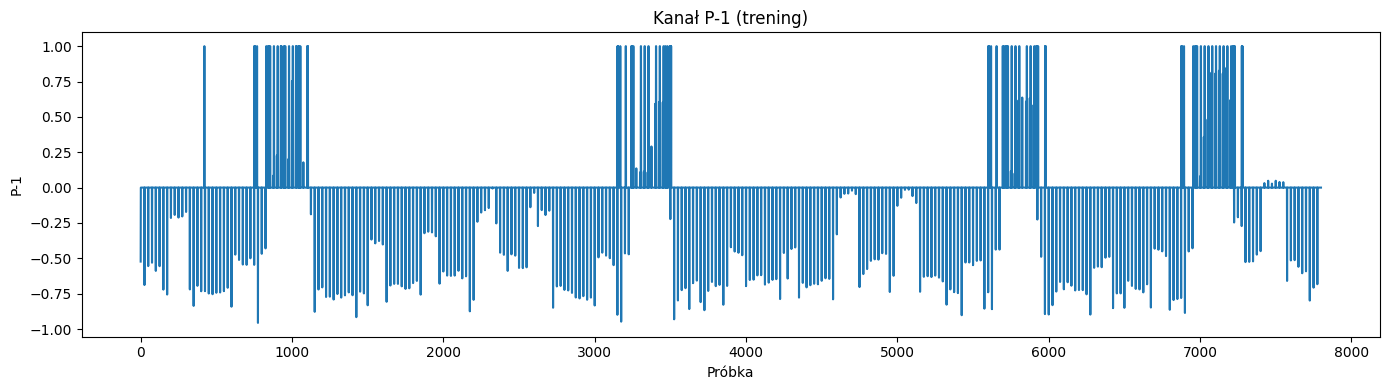

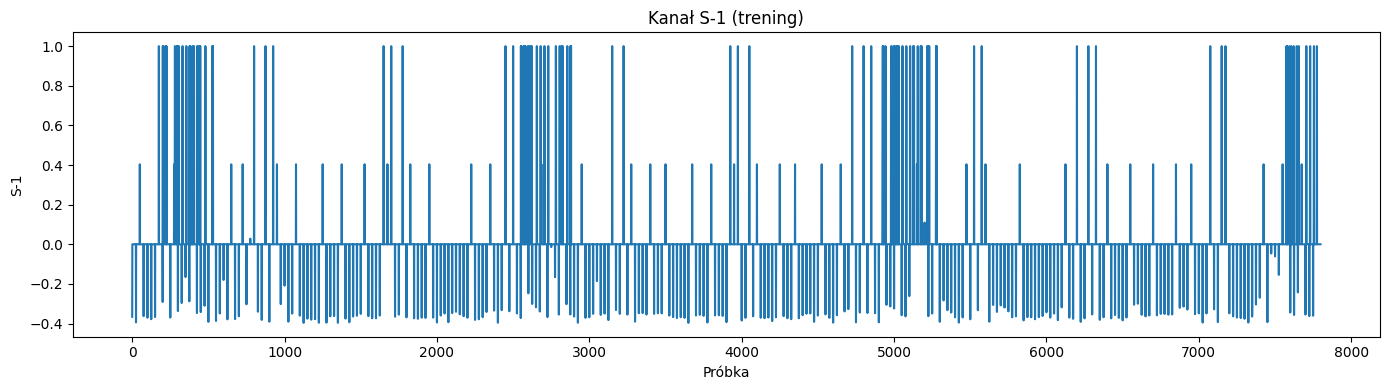

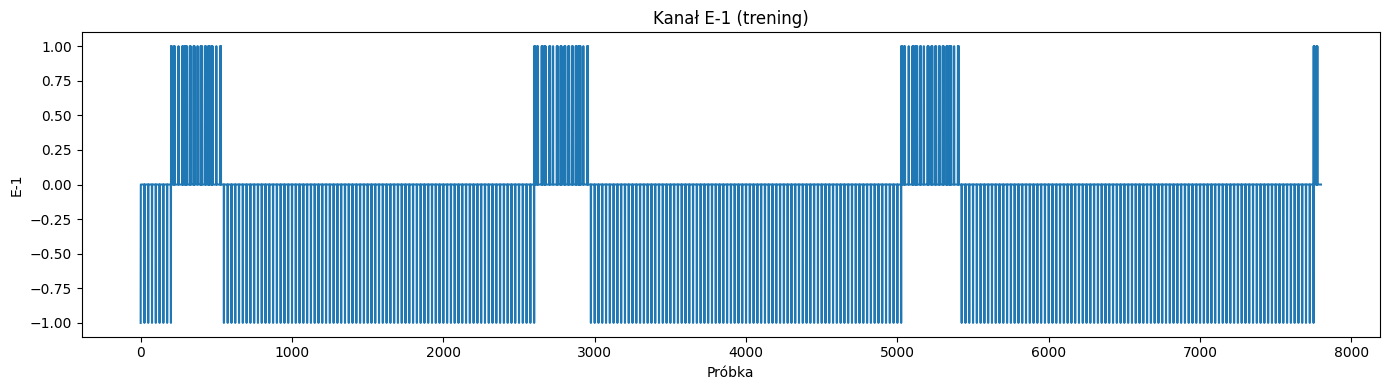

In [3]:
import matplotlib.pyplot as plt

num_channels_to_plot = 3
for channel in smap_channels[:num_channels_to_plot]:
    plt.figure(figsize=(14, 4))
    plt.plot(df[channel])
    plt.title(f'Kanał {channel} (trening)')
    plt.ylabel(channel)
    plt.xlabel('Próbka')
    plt.tight_layout()
    plt.show()

## Sprawdzenie dostępności GPU

In [4]:
import torch

if torch.cuda.is_available():
    print("GPU is available :)")
    device = torch.device("cuda")
else:
    print("GPU is NOT available, using CPU. :(")
    device = torch.device("cpu")

GPU is available :)


## Normalizacja danych

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df)
X = torch.tensor(df_normalized, dtype=torch.float32)

## Definicja autoencodera

In [6]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(X.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9)
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, X.shape[1]),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Nauka autoencodera

In [7]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = AE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 200
for epoch in range(epochs):
    total_loss = 0
    for batch in loader:
        x_batch = batch[0].to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, x_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(loader):.6f}")

Epoch 1/200, Loss: 0.030743
Epoch 2/200, Loss: 0.008685
Epoch 3/200, Loss: 0.007307
Epoch 4/200, Loss: 0.006999
Epoch 5/200, Loss: 0.006737
Epoch 6/200, Loss: 0.006399
Epoch 7/200, Loss: 0.006039
Epoch 8/200, Loss: 0.005759
Epoch 9/200, Loss: 0.005517
Epoch 10/200, Loss: 0.005277
Epoch 11/200, Loss: 0.005557
Epoch 12/200, Loss: 0.005086
Epoch 13/200, Loss: 0.004997
Epoch 14/200, Loss: 0.004933
Epoch 15/200, Loss: 0.004849
Epoch 16/200, Loss: 0.004789
Epoch 17/200, Loss: 0.004741
Epoch 18/200, Loss: 0.004661
Epoch 19/200, Loss: 0.004618
Epoch 20/200, Loss: 0.004571
Epoch 21/200, Loss: 0.004488
Epoch 22/200, Loss: 0.004408
Epoch 23/200, Loss: 0.004375
Epoch 24/200, Loss: 0.004254
Epoch 25/200, Loss: 0.004202
Epoch 26/200, Loss: 0.004132
Epoch 27/200, Loss: 0.004087
Epoch 28/200, Loss: 0.004058
Epoch 29/200, Loss: 0.004021
Epoch 30/200, Loss: 0.004067
Epoch 31/200, Loss: 0.003912
Epoch 32/200, Loss: 0.003861
Epoch 33/200, Loss: 0.003829
Epoch 34/200, Loss: 0.003821
Epoch 35/200, Loss: 0.0

## Zapis modelu do pliku

In [8]:
torch.save(model.state_dict(), "autoencoder_smap.pth")
print("Model został zapisany do 'autoencoder_smap.pth'")

Model został zapisany do 'autoencoder_smap.pth'


## Wczytanie modelu

In [9]:
model = AE().to(device)
model.load_state_dict(torch.load("autoencoder_smap.pth", map_location=device))

<All keys matched successfully>

## Autoencoder na zbiorze testowym

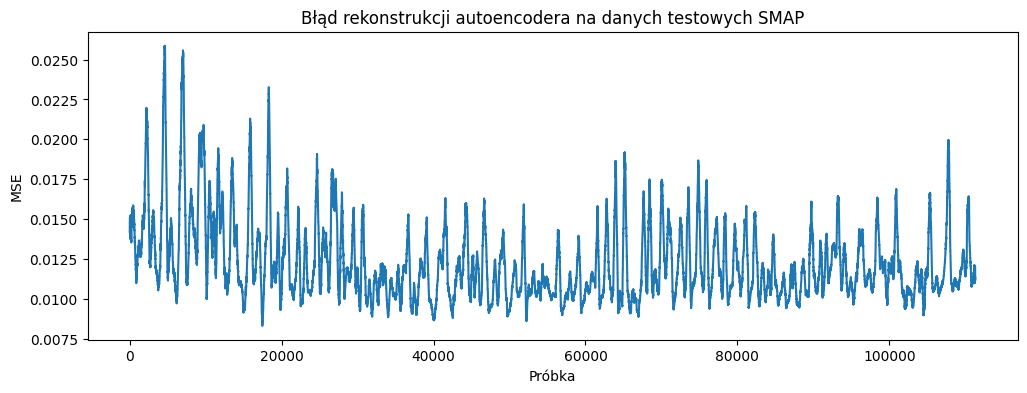

In [13]:
from scipy.ndimage import uniform_filter1d

# Dane testowe
test_data_dir = "data/test"
test_data = {}
for channel in smap_channels:
    npy_path = os.path.join(test_data_dir, f"{channel}.npy")
    if os.path.exists(npy_path):
        arr = np.load(npy_path)
        if arr.ndim > 1:
            arr = arr.flatten()
        test_data[channel] = arr
    else:
        print(f"Brak pliku: {npy_path}")

min_len = min(len(a) for a in test_data.values())
for k in test_data:
    test_data[k] = test_data[k][:min_len]

df_test = pd.DataFrame(test_data)
df_test_normalized = scaler.transform(df_test)
X_test = torch.tensor(df_test_normalized, dtype=torch.float32).to(device)

# Rekonstrukcja
model.eval()
with torch.no_grad():
    X_test_recon = model(X_test).cpu().numpy()

# Błąd rekonstrukcji
recon_error = np.mean((X_test.cpu().numpy() - X_test_recon) ** 2, axis=1)

window = 300
smooth_err = uniform_filter1d(recon_error, size=window)


plt.figure(figsize=(12,4))
plt.plot(smooth_err)
plt.title("Błąd rekonstrukcji autoencodera na danych testowych SMAP")
plt.xlabel("Próbka")
plt.ylabel("MSE")
plt.show()

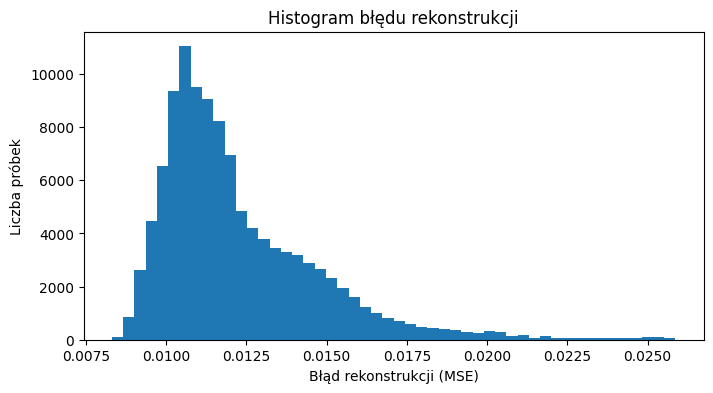

In [14]:
plt.figure(figsize=(8,4))
plt.hist(smooth_err, bins=50)
plt.title("Histogram błędu rekonstrukcji")
plt.xlabel("Błąd rekonstrukcji (MSE)")
plt.ylabel("Liczba próbek")
plt.show()

## Confusion matrix

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

threshold = np.percentile(smooth_err, 90)

predicted_anomaly = smooth_err > threshold

# Etykiety anomalii na podstawie labeled_anomalies.csv
true_anomaly = np.zeros(len(smooth_err), dtype=int)
for _, row in metadata[metadata['spacecraft'] == 'SMAP'].iterrows():
    for seq in eval(row['anomaly_sequences']):
        start, end = seq
        true_anomaly[start:min(end+1, len(true_anomaly))] = 1

print("Confusion matrix:")
print(confusion_matrix(true_anomaly, predicted_anomaly))
print("\nClassification report:")
print(classification_report(true_anomaly, predicted_anomaly, target_names=["Normal", "Anomaly"]))

Confusion matrix:
[[95967  8985]
 [ 4226  2147]]

Classification report:
              precision    recall  f1-score   support

      Normal       0.96      0.91      0.94    104952
     Anomaly       0.19      0.34      0.25      6373

    accuracy                           0.88    111325
   macro avg       0.58      0.63      0.59    111325
weighted avg       0.91      0.88      0.90    111325

